In [1]:
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

/Users/visser/drive/PhD/Code/pain-measurement


In [3]:
import logging
import math
import os
from pathlib import Path

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import panel as pn
import plotly.express as px
import polars as pl
import scipy
import scipy.signal as signal

from src.data.config_data import DataConfigBase
from src.data.config_data_raw import RAW_DICT, RAW_LIST, RawConfig
from src.data.config_participant import PARTICIPANT_LIST, ParticipantConfig
from src.data.make_dataset import load_dataset
from src.features.pupillometry import (
    _get_blink_segments,
    interpolate_pupillometry,
    remove_periods_around_blinks,
    values_below_x_are_considered_blinks,
)
from src.features.quality_checks import check_sample_rate
from src.features.transformations import (
    add_timedelta_column,
    interpolate,
    map_participant_datasets,
    map_trials,
    merge_dfs,
    scale_min_max,
    scale_standard,
)
from src.log_config import configure_logging
from src.visualization.plot_data import (
    plot_data_panel,
    plot_trial_matplotlib,
    plot_trial_plotly,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param"],
)

pl.Config.set_tbl_rows(7)  # don't print too many rows in the book
plt.rcParams["figure.figsize"] = [15, 5]  # default is [6, 4]

In [6]:
participant_number = 0
modality = "pupillometry"
data_config = RAW_DICT[modality]
sampling_rate = data_config.sampling_rate
eye_columns = ["Pupillometry_L", "Pupillometry_R"]

pupillometry_raw = load_dataset(
    PARTICIPANT_LIST[participant_number], RAW_DICT[modality]
).dataset
check_sample_rate(pupillometry_raw)

pupillometry_raw


def ensure_list(to_list):
    """Helper function for idempotently converting a string to a list."""
    return [to_list] if isinstance(to_list, str) else to_list

23:10:43 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 005_leo loaded from data/raw/005_leo/005_leo_pupillometry.csv
23:10:43 | DEBUG   | quality_check | Sample rate per trial: [59.93 59.92 59.93 59.92 59.93 59.93 59.92 59.92 59.92 59.94 59.91 59.93]
23:10:43 | INFO    | quality_check | The mean sample rate is 59.92.


In [12]:
participant_number = 0
modality = "pupillometry"
data_config = RAW_DICT[modality]
pupillometry_raw = load_dataset(
    PARTICIPANT_LIST[participant_number], RAW_DICT[modality]
).dataset

23:11:50 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 005_leo loaded from data/raw/005_leo/005_leo_pupillometry.csv


:Histogram   [duration]   (duration_count)

In [5]:
pupillometry_raw.plot(x="Timestamp", y=eye_columns, title="Raw Pupillometry Data")

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [13]:
results = []
for participant in PARTICIPANT_LIST:
    pupillometry_raw = load_dataset(participant, RAW_DICT[modality]).dataset
    result = pupillometry_raw.group_by("Trial", maintain_order=True).map_groups(
        lambda group: _get_blink_segments(group, eye_columns)
    )
    results.append(result)

pl.concat(results).select("duration").plot.hist(
    bins=1000, title="Blink Duration Distribution"
)

23:12:44 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 005_leo loaded from data/raw/005_leo/005_leo_pupillometry.csv


:Histogram   [duration]   (duration_count)

In [7]:
pupillometry_raw.plot(
    x="Timestamp", y="Pupillometry_L", kind="line", title="Pupillometry_L"
)

:Curve   [Timestamp]   (Pupillometry_L)

In [8]:
pupillometry_raw = values_below_x_are_considered_blinks(pupillometry_raw, eye_columns)
pupillometry_segmented = remove_periods_around_blinks(
    pupillometry_raw, eye_columns, period=150
)
pupillometry_segmented.plot(
    x="Timestamp",
    y=eye_columns,
    xlim=(900000, 1000000),
    kind="line",
    title="Pupillometry_L",
)

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [9]:
pupillometry_interpolated = interpolate_pupillometry(
    pupillometry_segmented, eye_columns
)
pupillometry_interpolated.plot(
    x="Timestamp",
    y=eye_columns,
    xlim=(900000, 1000000),
    kind="line",
    title="Pupillometry_L",
)

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [10]:
data = pupillometry_interpolated[eye_columns].to_numpy()
data.shape

(16783, 2)

In [11]:
import numpy as np
from scipy.linalg import inv

# Example pupillometry data for both eyes
data = pupillometry_interpolated[eye_columns].to_numpy()

# Replace this with your actual data

# Define the number of states
n_states = 1  # Assuming we're only tracking one dimension of the pupil size

# State transition matrix (A)
A = np.eye(n_states)

# Observation matrix (H)
H = np.ones(
    (2, n_states)
)  # Maps the n_states-dimensional state to the 2-dimensional observation space

# Process noise covariance (Q)
Q = np.eye(n_states) * 0.01  # Adjust this value based on your data

# Measurement noise covariance (R)
R = np.eye(2) * 0.01  # Adjust this value based on your data

# Initial estimate error covariance (P)
P = np.eye(n_states) * 1

# Initial state estimate (x)
x = np.zeros((n_states, 1))

# Placeholder to store the filtered state
filtered_state_means = np.zeros((len(data), n_states))

for t in range(len(data)):
    # Time update (Prediction)
    x = A.dot(x)  # State prediction
    P = A.dot(P).dot(A.T) + Q  # Error covariance prediction

    # Measurement update (Correction)
    S = H.dot(P).dot(H.T) + R  # System uncertainty
    K = P.dot(H.T).dot(inv(S))  # Kalman gain
    y = data[t].reshape(-1, 1) - H.dot(x)  # Measurement residual
    x = x + K.dot(y)  # State update
    P = (np.eye(n_states) - K.dot(H)).dot(P)  # Error covariance update

    # Save the state estimate
    filtered_state_means[t] = x.ravel()

# Use `filtered_state_means` as the estimate of the true pupil diameters
filtered_state_means

array([[3.53495778],
       [3.54833033],
       [3.55595907],
       ...,
       [3.70659312],
       [3.71023219],
       [3.712608  ]])

In [12]:
filtered_state_means.flatten()

array([3.53495778, 3.54833033, 3.55595907, ..., 3.70659312, 3.71023219,
       3.712608  ])

In [13]:
# Add to the original dataframe
pupillometry_interpolated = pupillometry_interpolated.with_columns(
    pl.Series("Pupillometry", filtered_state_means.flatten())
)

In [14]:
pupillometry_interpolated.plot(
    x="Timestamp",
    y=["Pupillometry_L", "Pupillometry_R", "Pupillometry"],
    xlim=(900000, 1000000),
    kind="line",
    title="Pupillometry_L",
)

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [15]:
import numpy as np
from scipy.linalg import inv

# Replace this with your actual data
data = pupillometry_interpolated[eye_columns].to_numpy()

# Define the number of states
n_states = 1  # Assuming we're only tracking one dimension of the pupil size

# State transition matrix (A)
A = np.eye(n_states)

# Observation matrix (H)
H = np.ones(
    (2, n_states)
)  # Maps the n_states-dimensional state to the 2-dimensional observation space

# Process noise covariance (Q)
Q = np.eye(n_states) * 0.01  # Adjust this value based on your data

# Measurement noise covariance (R)
R = np.eye(2) * 0.01  # Adjust this value based on your data

# Initial estimate error covariance (P)
P = np.eye(n_states) * 1

# Initial state estimate (x)
x = np.zeros((n_states, 1))

# Placeholder to store the filtered state
filtered_state_means = np.zeros((len(data), n_states))

# Precompute the static inverse of R if it's constant and invertible
R_inv = inv(R)

# We will also precompute the Identity matrix of shape (n_states, n_states)
I = np.eye(n_states)

for t in range(len(data)):
    # Time update (Prediction)
    # x and P are updated in place to avoid unnecessary memory allocation
    np.dot(A, x, out=x)
    # Use 'at' for in-place dot product for updating P
    np.dot(A, P, out=P)
    np.dot(P, A.T, out=P)
    P += Q

    # Measurement update (Correction)
    # Compute the system uncertainty in place
    S = H.dot(P).dot(H.T) + R
    # Compute the Kalman gain in place
    K = P.dot(H.T).dot(inv(S))

    # Compute the measurement residual in place
    y = data[t].reshape(-1, 1) - H.dot(x)

    # State update in place
    np.dot(K, y, out=y)
    x += y

    # Error covariance update in place
    # Use 'at' for in-place dot product for updating P
    np.dot(K, H, out=K)
    P -= K.dot(P)

    # Save the state estimate directly into the array
    filtered_state_means[t] = x.ravel()

# The resulting `filtered_state_means` is your estimate of the true pupil diameters

ValueError: output array has wrong dimensions

In [ ]:
import numpy as np


def moving_average(data, window_size):
    """Computes moving average using a window of the specified size."""
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, "same")


# Example usage:
pupil_data = np.random.rand(100, 2)  # Replace this with your actual data
window_size = 5  # Define the window size that you want
smoothed_data = np.zeros_like(pupil_data)
for i in range(pupil_data.shape[1]):
    smoothed_data[:, i] = moving_average(pupil_data[:, i], window_size)

smoothed_data.shape

(100, 2)

In [ ]:
import simdkalman

kf = simdkalman.KalmanFilter(
    state_transition=np.array([[1, 1], [0, 1]]),
    process_noise=np.diag([0.1, 0.01]),
    observation_model=np.array([[1, 0]]),
    observation_noise=1.0,
)

data = np.random.normal(size=(200, 1000))

# smooth and explain existing data
smoothed = kf.smooth(data)
# predict new data
pred = kf.predict(data, 15)

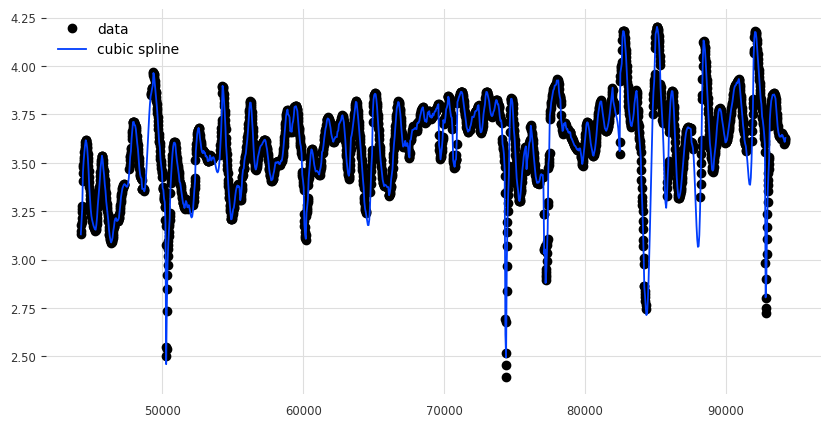

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Example data points
y = pupillometry_segmented["Pupillometry_L"].to_numpy()[1000:4000]
x = pupillometry_segmented["Timestamp"].to_numpy()[1000:4000]

# Remove NaN values
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

# Perform the cubic spline interpolation
cs = CubicSpline(x, y)

# Create a range of values for which we want to predict new y values using the spline
x_new = np.linspace(x.min(), x.max(), 1000)
y_new = cs(x_new)

# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(x, y, "o", label="data")
plt.plot(x_new, y_new, label="cubic spline")
plt.legend(loc="best")
plt.show()

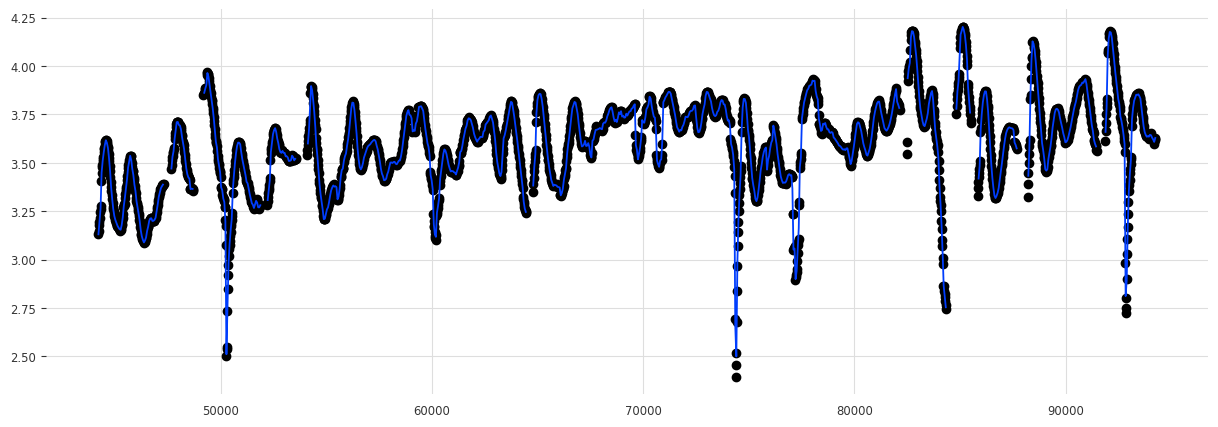

In [ ]:
# scipy intrpolate1d
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

y = pupillometry_segmented["Pupillometry_L"].to_numpy()[1000:4000]
x = pupillometry_segmented["Timestamp"].to_numpy()[1000:4000]

f = scipy.interpolate.interp1d(x, y, kind="linear", fill_value="extrapolate")

xnew = np.linspace(x[0], x[-1], num=1000, endpoint=True)
ynew = f(xnew)  # use interpolation function returned by `interp1d`
plt.plot(x, y, "o", xnew, ynew, "-")

In [ ]:
scipy.interpolate.interp1d(
    x, kind="linear", axis=-1, copy=True, bounds_error=None, assume_sorted=False
)

TypeError: interp1d.__init__() missing 1 required positional argument: 'y'

NOTE: maybe add length condition to separate blinks from head turn + larger gaps fot the latter?